# General

## Imports

In [ ]:
!pip install catboost
!pip install simple-colors
!pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import pyarrow.parquet as pq
from simple_colors import *

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 7)
%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
# Data upload
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/train1.csv
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/test1.csv
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/id_map.parquet

## Description

This dataset contains user transitions between pages. The goal of this challenge is to recognize one user amongst all others. The dataset consists of user sessions, each session is a sequence of transitions between pages. A sequence can be one to ten pages long.

* train.csv - contains webpages, timestamps, and targets for each train session.
* test.csv - contains webpages, timestamps for each test session.
* id_map.parquet - webpages id to url map

## Data overview

In [ ]:
# Reading the data with correct data type for dates
train = pd.read_csv('train1.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
test = pd.read_csv('test1.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
urls = pq.read_table('id_map.parquet').to_pandas()

In [ ]:
# Checking data view
train.head()

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
0,9486,2019-02-20 05:57:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,11722,2019-02-22 07:14:50,12385.0,2019-02-22 07:14:50,50163.0,2019-02-22 07:14:51,12385.0,2019-02-22 07:14:51,12398.0,2019-02-22 07:14:51,50150.0,2019-02-22 07:14:51,50163.0,2019-02-22 07:14:52,50150.0,2019-02-22 07:14:52,19860.0,2019-02-22 07:15:15,19886.0,2019-02-22 07:15:16,0
2,192149,2018-12-16 12:35:17,659.0,2018-12-16 12:35:18,192136.0,2018-12-16 12:35:19,192149.0,2018-12-16 12:35:19,633.0,2018-12-16 12:35:19,659.0,2018-12-16 12:35:19,192136.0,2018-12-16 12:35:20,192136.0,2018-12-16 12:35:21,192136.0,2018-12-16 12:35:22,192136.0,2018-12-16 12:35:24,0
3,10591,2019-02-13 12:40:35,451.0,2019-02-13 12:40:35,77580.0,2019-02-13 12:40:35,227821.0,2019-02-13 12:40:35,633.0,2019-02-13 12:41:05,425.0,2019-02-13 12:42:14,10591.0,2019-02-13 12:42:14,227834.0,2019-02-13 12:42:15,227834.0,2019-02-13 12:42:16,227834.0,2019-02-13 12:42:17,0
4,438,2018-04-12 06:22:26,425.0,2018-04-12 06:22:26,529.0,2018-04-12 06:22:28,65685.0,2018-04-12 06:22:29,187638.0,2018-04-12 06:22:29,451.0,2018-04-12 06:22:29,425.0,2018-04-12 06:22:29,65685.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:32,0


In [ ]:
# Data types of dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159969 entries, 0 to 159968
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   webpage1   159969 non-null  int64         
 1   time1      159969 non-null  datetime64[ns]
 2   webpage2   157990 non-null  float64       
 3   time2      157990 non-null  datetime64[ns]
 4   webpage3   156066 non-null  float64       
 5   time3      156066 non-null  datetime64[ns]
 6   webpage4   154402 non-null  float64       
 7   time4      154402 non-null  datetime64[ns]
 8   webpage5   152841 non-null  float64       
 9   time5      152841 non-null  datetime64[ns]
 10  webpage6   151324 non-null  float64       
 11  time6      151324 non-null  datetime64[ns]
 12  webpage7   149912 non-null  float64       
 13  time7      149912 non-null  datetime64[ns]
 14  webpage8   148574 non-null  float64       
 15  time8      148574 non-null  datetime64[ns]
 16  webpage9   147160 no

* We can see that all dates now have correct data type, and webpages are floates, but actually they are just ids to map of urls, so they should be analysed not as numerical data but as categorical
* We have missing value in our dataset which will be analysed in next section

In [ ]:
# Checking for duplicates
train.duplicated().sum()

16

* There are duplicates in this dataset, but I decided don't delete them as they have different session id, which means they can be not duplicated but just similar values
* anyway there amount is too small to have any noticable impact

In [ ]:
# Separating the target from train dataset
target = train.target
train = train.drop(columns='target')

# Missing values

Let's check how many missing values we have in dataset

In [ ]:
# Percentage of missing values for each feature
train.isna().sum()/len(train)

webpage1     0.000000
time1        0.000000
webpage2     0.012371
time2        0.012371
webpage3     0.024398
time3        0.024398
webpage4     0.034800
time4        0.034800
webpage5     0.044559
time5        0.044559
webpage6     0.054042
time6        0.054042
webpage7     0.062868
time7        0.062868
webpage8     0.071233
time8        0.071233
webpage9     0.080072
time9        0.080072
webpage10    0.088223
time10       0.088223
dtype: float64

Text(0.5, 1.0, 'Missing values')

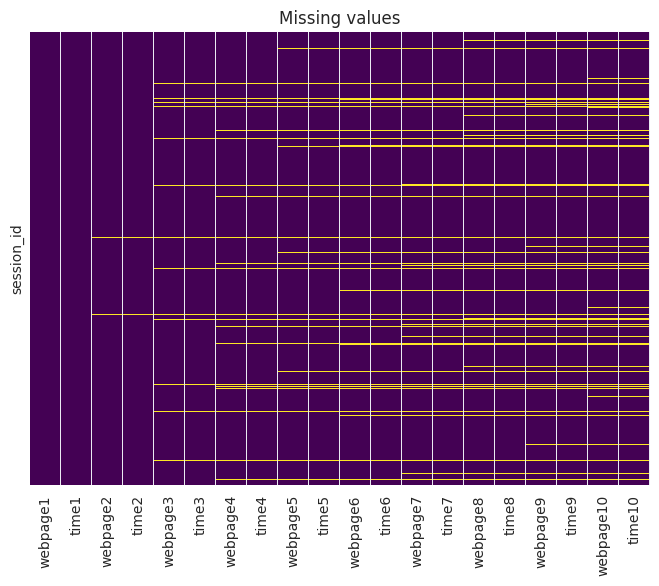

In [ ]:
# Visualization for missing values
plt.figure(figsize=(8,6), dpi=100)
sns.heatmap(train.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')
plt.title('Missing values')

* We can see that there are the biggest amount of missing values for webpage10 and time10 features, but still they are less then 9%, so it's not a lot
* If to check visualization and percentage counting then we can see that missing values are not actually something that was not written, they are just smaller amount of pages in the session
* So missing values can be filled with zero as it will not change our information about sessions 
* it will be done in next section

# Adding new features

To get more information about sessions and target user some new features will be added

In [ ]:
# Function for adding some numerical metrics and handling missing values
def preproc(df):
    return (
        df.assign(
            # difference between 10th page and 1st in seconds
            first_last_diff=lambda x: (x.time10 - x.time1).dt.seconds.fillna(0),
            # number of missing pages (from 10 max)
            nans_count=lambda x: x.isna().sum(axis=1).div(2),
            # number of unique pages in session
            n_unique_pages=lambda x: 
                x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1) / (10 - x.nans_count),
            # avg hour of day in a session
            avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1),
            # avg day of week in a session
            avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1),
        )
        # fill missing pages with zeros
        .fillna(0.)
    )

# Helper function for adding part of day
def part_of_day(column, new_column, df):
  # morning = 1, midday = 2, evening = 3, night = 4
  df[new_column] = 0
  for i in df.index:
    val = df.loc[i, column]
    if (val>=7) & (val <=11):
      df[new_column][i] = 1
    elif (val>=12) & (val <=18):
      df[new_column][i]  = 2
    elif (val>=19) & (val <=23):
      df[new_column][i]  = 3
    else:
      df[new_column][i]  = 4

# Function for adding some ordinal categorical features
def add_features(df):
  df['start_hour'] = df.time1.apply(lambda t: t.hour) # start hour for every session
  df['day_of_week'] = df.time1.apply(lambda t: t.weekday()) # start day of week for every session
  df['month'] = df.time1.apply(lambda t: t.month) # month for every session
  df['year'] = df.time1.apply(lambda t: t.year) # year for every session
  part_of_day('start_hour', 'part_OD', df) # starting part for day of every session
  df.drop(columns=[f'time{i+1}' for i in range(10)], inplace=True) # dropping time columns as all information from them was extracted
  return df

All preprocessing, dropping features, encoding and so on will be done on both train and target, and for validation check train will be splitted before modelling

In [ ]:
# Adding new features to train and test datasets
train = add_features(preproc(train))
test = add_features(preproc(test))

After adding all features we can check visualizations of their distributions in EDA section

# EDA

First columns where splitted on 2 list and then few functions for plotting were created

In [ ]:
cat_list = ['avg_day', 'start_hour', 'part_OD', 'day_of_week', 'month', 'year']
num_list = ['nans_count', 'n_unique_pages', 'avg_hour', 'first_last_diff', 'webpage1', 'webpage2', 'webpage3', 'webpage4', 'webpage5', 'webpage6',
       'webpage7', 'webpage8', 'webpage9', 'webpage10']

In [ ]:
def plot_cat(data, columns, target):
  for stat in columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.countplot(data[target == 1][stat], ax=ax1, color='green', alpha=0.8)
    ax1.set_title('Target user')
    sns.countplot(data[target == 0][stat], ax=ax2, color='red', alpha=0.8)
    ax2.set_title('Other users')
    fig.suptitle(stat)

In [ ]:
def plot_num(data, columns, target):
  for stat in columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(data[target == 1][stat], ax=ax1, color='green')
    ax1.set_title('Target user')
    sns.distplot(data[target == 0][stat], ax=ax2, color='red')
    ax2.set_title('Other users')
    fig.suptitle(stat)

## Target

In [ ]:
# Percentage of 1 and 0 for target variable
target.value_counts(True)

0    0.990154
1    0.009846
Name: target, dtype: float64

Text(0.5, 1.0, 'Target distribution')

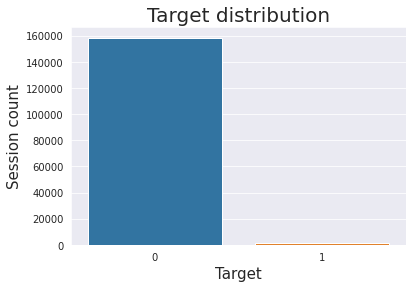

In [ ]:
# Visualization for target variable distribution
sns.countplot(target)
plt.xlabel('Target', fontsize=15)
plt.ylabel('Session count', fontsize=15)
plt.title('Target distribution', fontsize=20)

* As we can see data is very unbalanced, and our target user 1 is minor class, represented with appr. 1% of data
* Some techniques for fixing balance can be used, but in real life it is correct nature of data, as one user is always much less then all others

## Categorical features

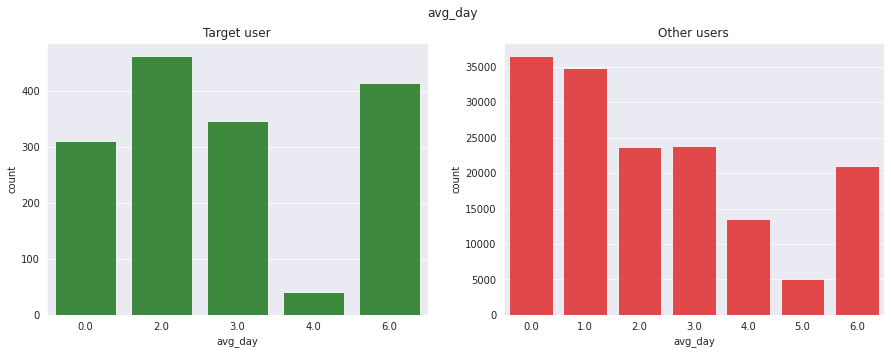

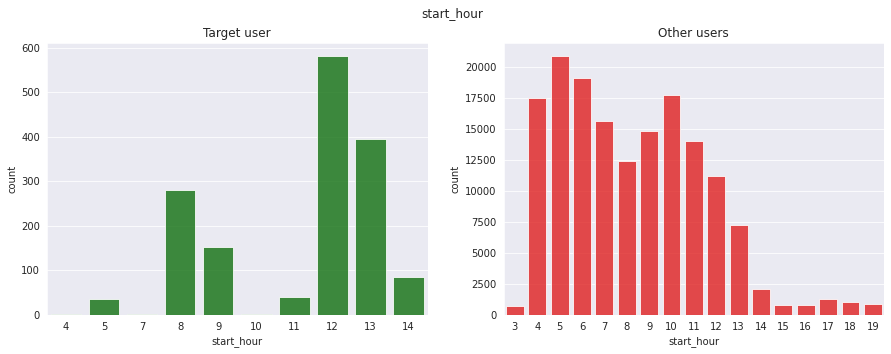

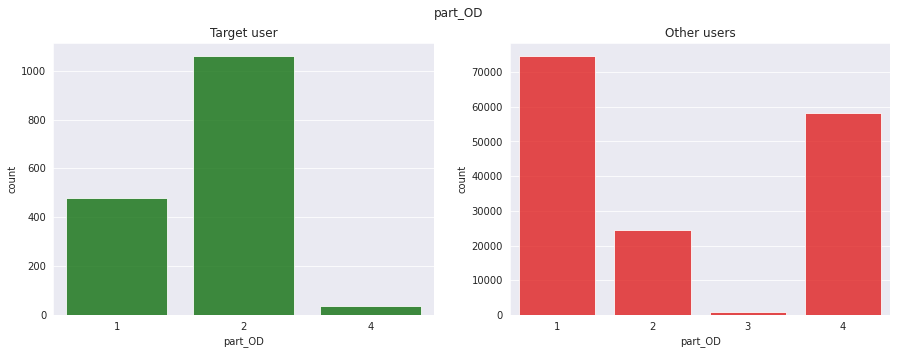

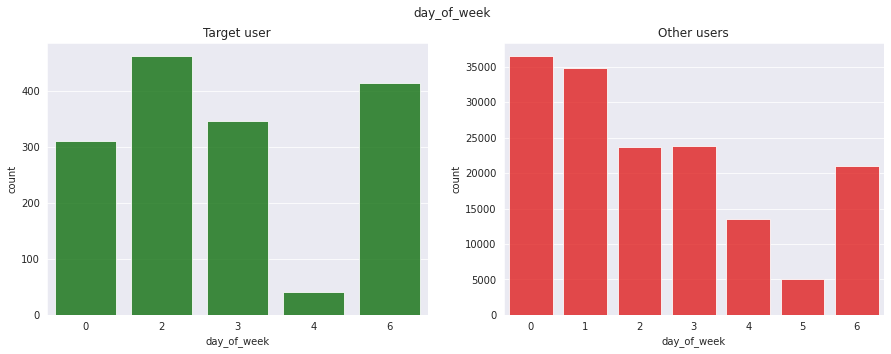

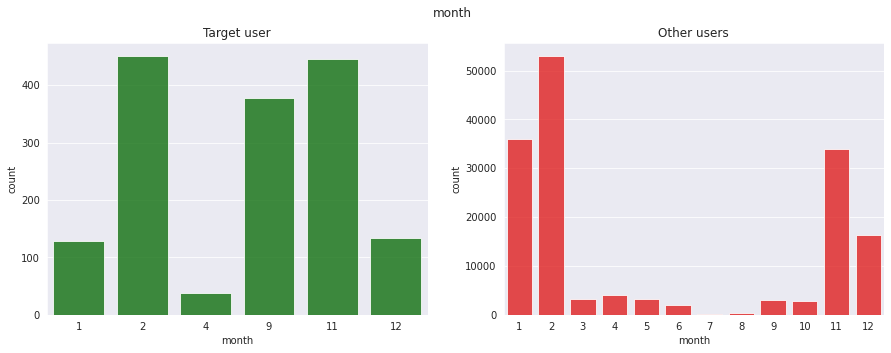

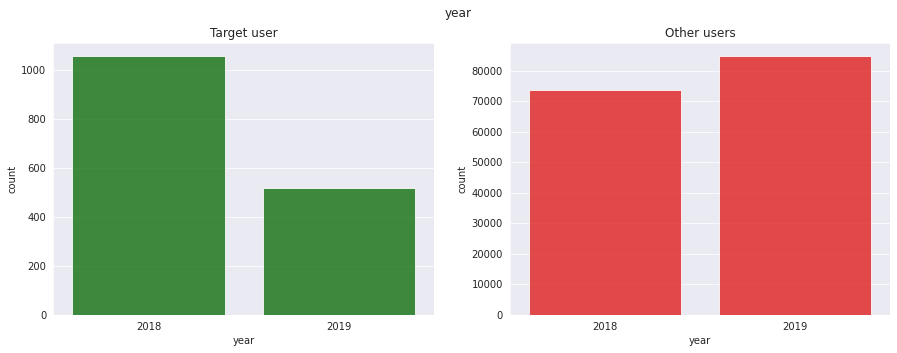

In [ ]:
# Visualization for ordered categorical features compared for target user and others
plot_cat(train, cat_list, target)

* As we can see for all features distributions are different for target users and others. 
* Target user has more specific month, day of week and part of day
* For year target user was more active in 2019, but others in 2018
* Also year can be replaced as 1 and 0 for 2019/2018

In [ ]:
train.replace({'year' : { 2019 : 1, 2018 : 0}}, inplace=True)
test.replace({'year' : { 2019 : 1, 2018 : 0}}, inplace=True)

## Numerical features

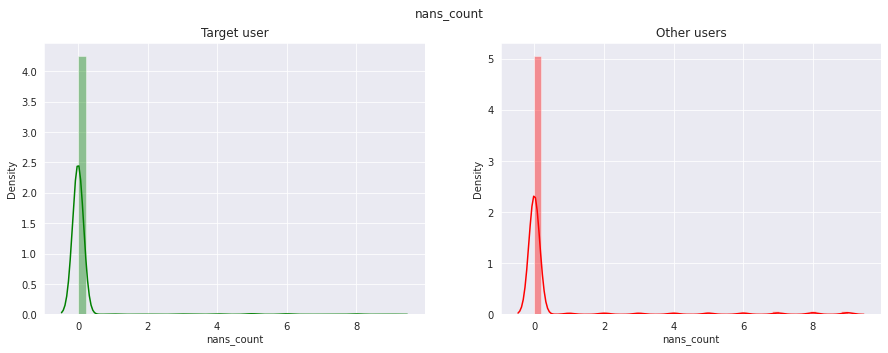

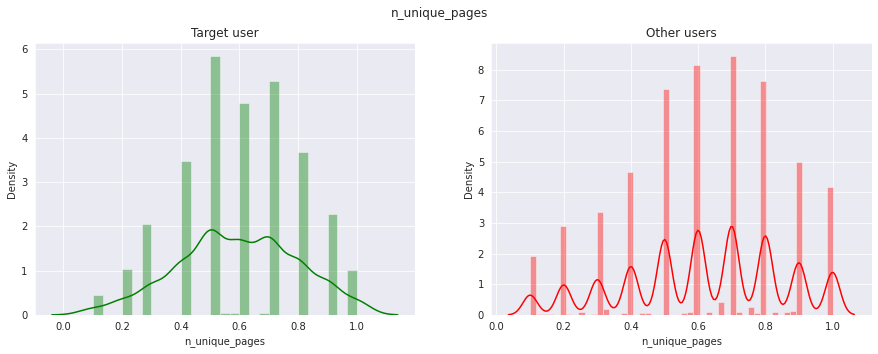

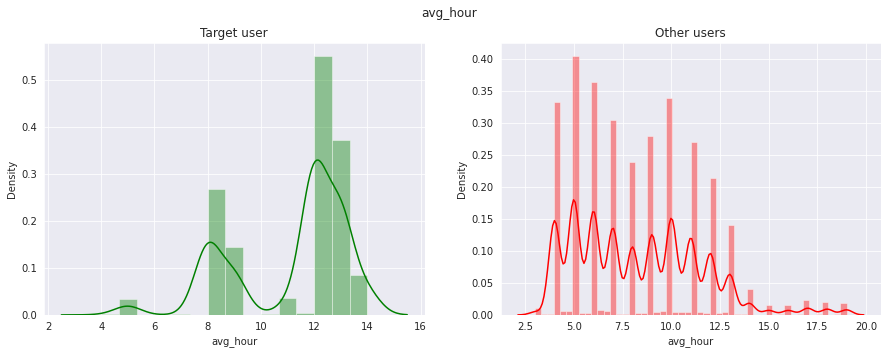

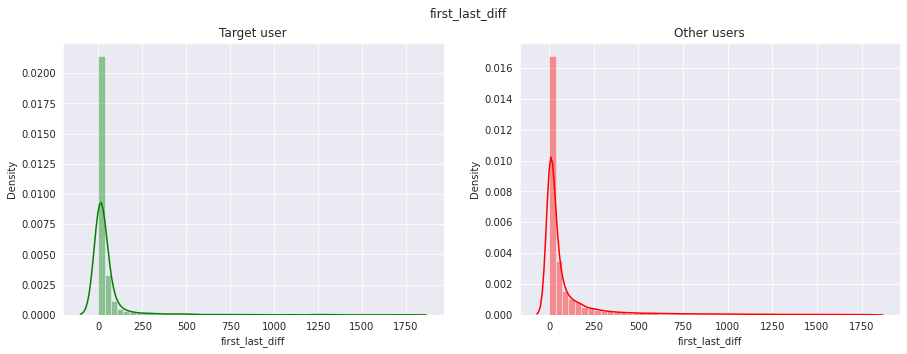

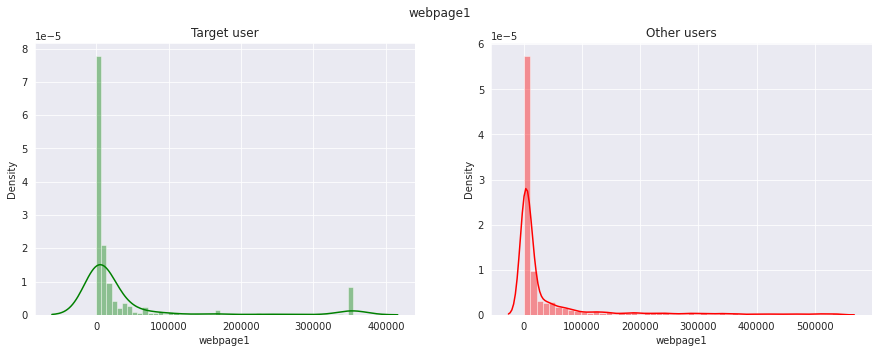

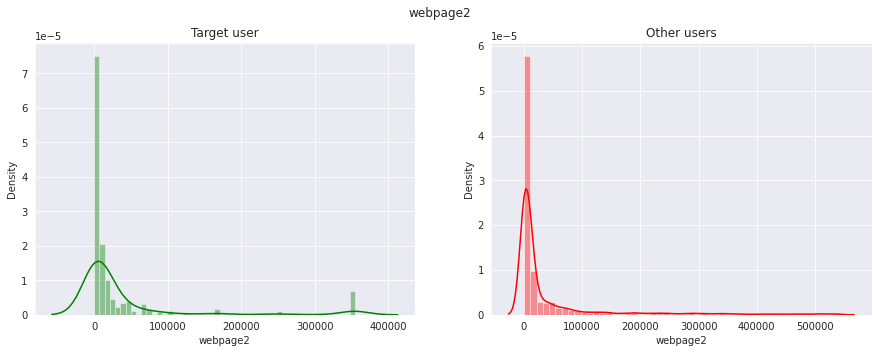

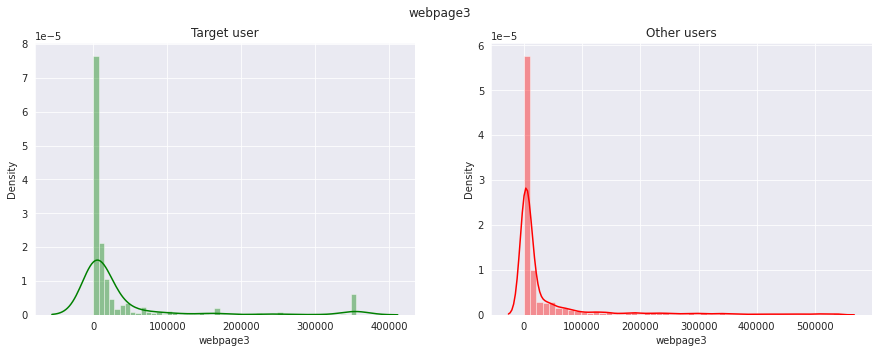

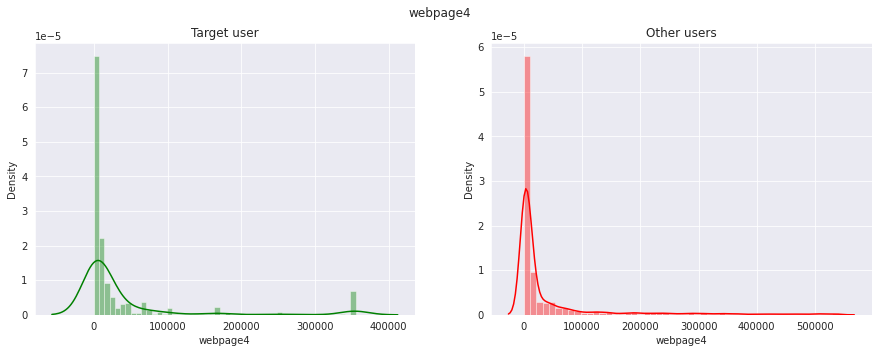

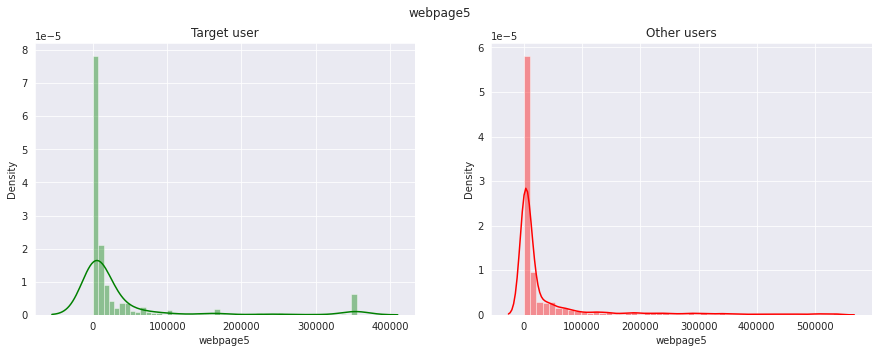

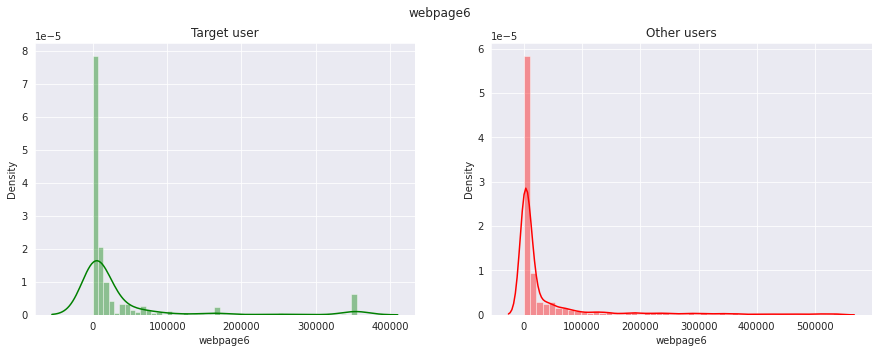

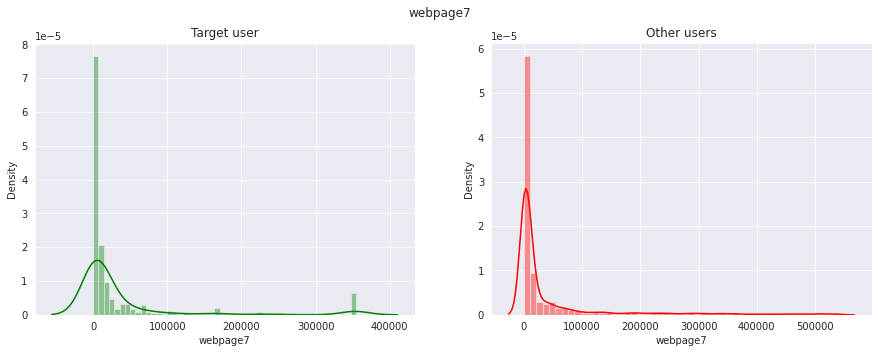

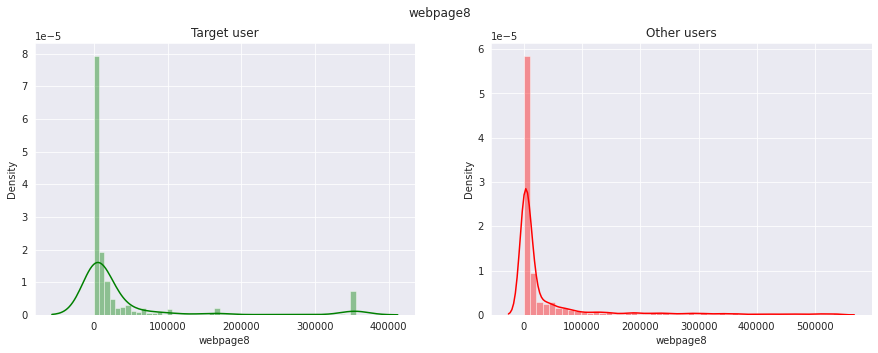

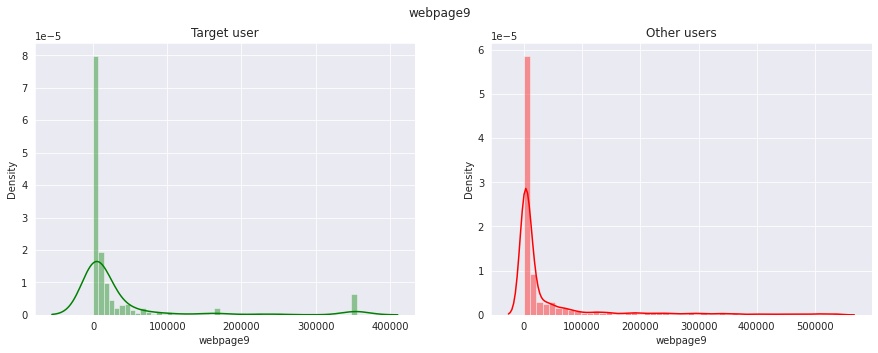

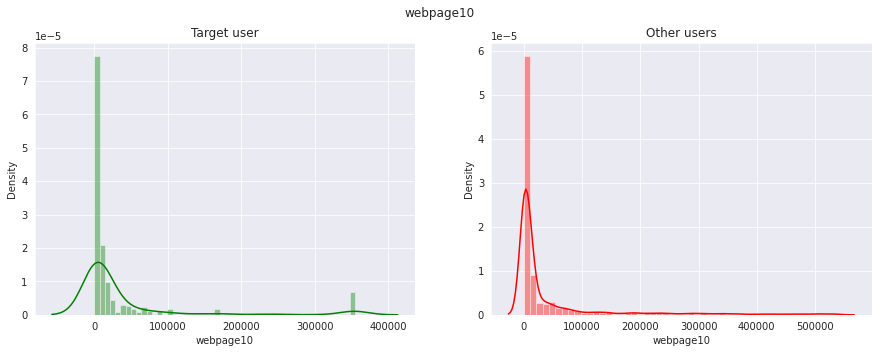

In [ ]:
# Visualization for numerical features compared for target user and others
plot_num(train, num_list, target)

* As we can see for number of unique pages and average hour distributions are different for target users and others. 
* For webpages plotting was done with numerical features but actually those are categorical features encoded with some numerical ids, and as we can see from the plots from 410000 ids are only for others users, target user don’t have them

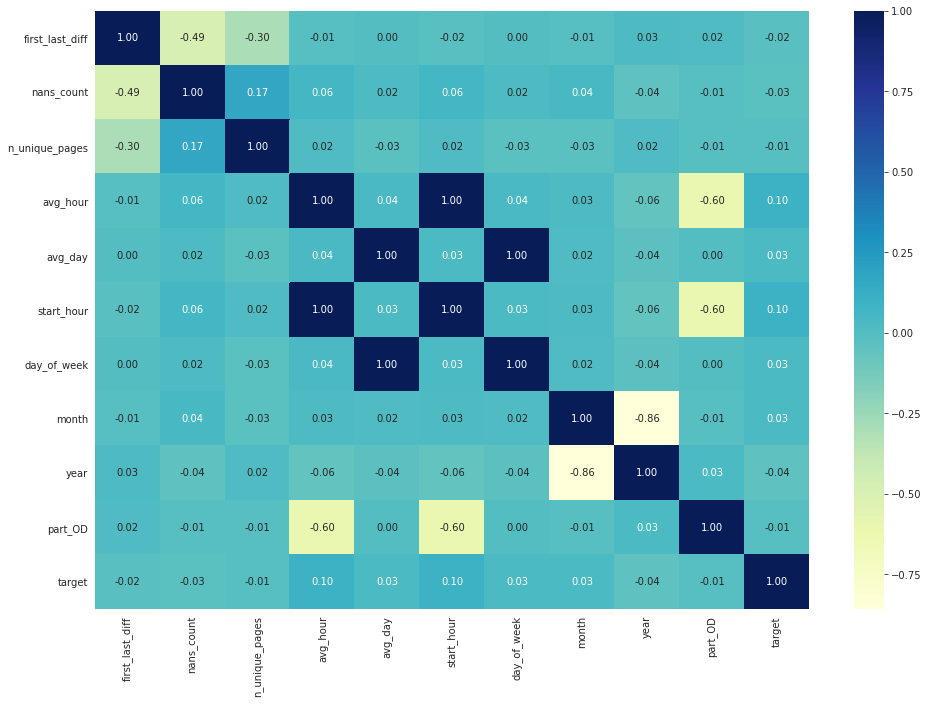

In [ ]:
# Visualization for checking correlation
train_for_corr = train[['first_last_diff', 'nans_count', 'n_unique_pages', 'avg_hour', 'avg_day', 'start_hour', 'day_of_week', 'month', 'year', 'part_OD']]
corr_df = pd.concat([train_for_corr,target], axis=1)
corr = corr_df.corr('spearman') 
plt.figure(figsize = (16 , 11)) 
sns.heatmap(corr, annot=True, fmt='.2f', cmap="YlGnBu");

We can see that day of week and avg day, start hour and avg hour are highly correlated, so we can drop day of week and start hour to avoid multicollinearity

In [ ]:
# Dropping day of week and start hour features
train.drop('day_of_week', axis=1, inplace=True)
train.drop('start_hour', axis=1, inplace=True)
test.drop('day_of_week', axis=1, inplace=True)
test.drop('start_hour', axis=1, inplace=True)

## Top webpages analysis

In this section top webpages visited will be checked for target and others users, also visualization will be done

In [ ]:
# Function for extracting string urls from mapping dataset
def add(data,  url_df, n=10):
  url_list = []
  for i in range(n):
    id_n = data.index[i]
    url = url_df.loc[url_df['id'] == id_n]['webpage'].iloc[0]
    url_list.append(url)
  return url_list

# Creating helper list of column's names for webpages
webpages = ['webpage%s' % i for i in range(1, 11)]

In [ ]:
# Extracting ids for top 10 webpages for not target 0 (other users)
top_sites_zero = pd.Series(train[target==0][webpages]
                           .values
                           .flatten()
                           ).value_counts().sort_values(ascending=False).head(11)
top_sites_zero = pd.DataFrame(top_sites_zero)

# Zeros are deleted as those are not existing webpages
top_sites_zero = top_sites_zero.drop(0.0)
top_sites_zero

,0
425.0,80224
451.0,58876
438.0,38144
529.0,35050
2323.0,28663
10708.0,24969
828.0,23330
1192.0,22015
7562.0,20853
867.0,18047


In [ ]:
# Extracting ids for top 10 webpages for target user
top_sites_one = pd.Series(train[target==1][webpages]
                           .values
                           .flatten()
                           ).value_counts().sort_values(ascending=False).head(10)
top_sites_one = pd.DataFrame(top_sites_one)
top_sites_one

,0
1192.0,1147
1140.0,973
1153.0,915
529.0,645
425.0,627
1205.0,477
11579.0,377
1218.0,304
451.0,293
438.0,277


* Few webpages are specific for our target user at least in top 10 list, so it is important information that can be used for finding target user
* We can see that some webpages are common for both target and others users, but they have not similar places in the sorted list
* Let's add url names to our webpages ids


In [ ]:
# Merging ids and urls of webpages
web_df = pd.melt(train, value_vars=webpages, value_name='id')
web_url_df = web_df.merge(urls, on='id', how='left')

In [ ]:
# Adding urls to top webpages 
top_sites_zero['web_names'] = add(top_sites_zero, web_url_df, 10)
top_sites_one['web_names'] = add(top_sites_one, web_url_df, 10)

Text(0.5, 1.0, 'Top 10 webpages for other users')

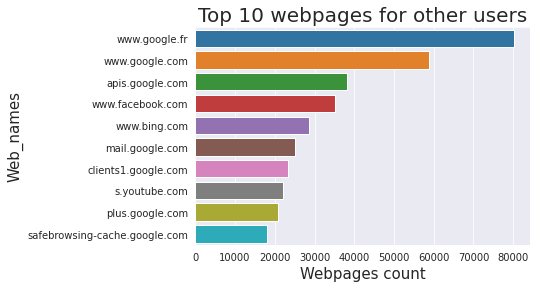

In [ ]:
# Visualization of top 10 webpges for other then target users
sns.barplot(x=0, y="web_names", data=top_sites_zero)
plt.xlabel('Webpages count', fontsize=15)
plt.ylabel('Web_names', fontsize=15)
plt.title('Top 10 webpages for other users', fontsize=20)

Text(0.5, 1.0, 'Top 10 webpages for target user')

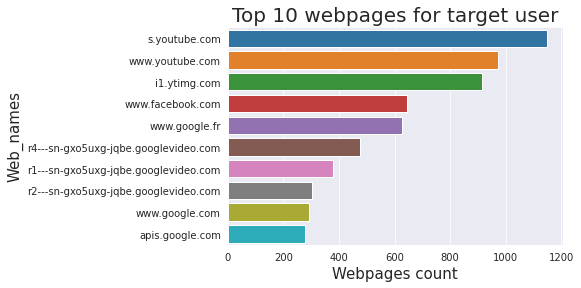

In [ ]:
# Visualization of top 10 webpges for target user
sns.barplot(x=0, y="web_names", data=top_sites_one)
plt.xlabel('Webpages count', fontsize=15)
plt.ylabel('Web_names', fontsize=15)
plt.title('Top 10 webpages for target user', fontsize=20)

* As we can see there are some pretty specific for target user webpages as i1.ytimg.com and *.googlevideo.com
* Also for others users some webpages are common with target user, but some differ like bing.com, mail and clients1.google.com

# Models

In [ ]:
# Function for fitting and estimating model
def fit_est_model(X_tr, y_tr, X_ts, y_ts, model, title):
  model.fit(X_tr, y_tr)
  y_pred = model.predict(X_ts)
  y_pred_prob = model.predict_proba(X_ts)[:,1]
  print(red(title, ['bold']))
  print('AUC_ROC:', blue(roc_auc_score(y_ts, y_pred_prob), ['bold']))
  print('\nREPORT:\n', classification_report(y_pred, y_ts))
  return y_pred_prob, y_pred

## Baseline

In [ ]:
# Splitting training dataset onto train and validation subsets
train_X, val_X, train_y, val_y = train_test_split(train, target, test_size = 0.20, stratify=target, random_state=0)

For our tast AUC_ROC score was defined for models estimation, but classification report also will be used to see some additional results

In [ ]:
# Group of some basic models for initial checking ROC_AUC scores
lr = LogisticRegression()
gnb = GaussianNB()
dt = DecisionTreeClassifier(max_depth=7)
rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(objective ='binary:logistic')
lgbm = LGBMClassifier(n_estimators=1000)
catb = CatBoostClassifier(verbose=False)

In [ ]:
# Fitting and estimating all models
y_pred_pr_lr, y_pred_lr = fit_est_model(train_X, train_y, val_X, val_y, lr, 'LR')
y_pred_pr_gnb, y_pred_gnb = fit_est_model(train_X, train_y, val_X, val_y, gnb, 'GNB')
y_pred_pr_dt, y_pred_dt = fit_est_model(train_X, train_y, val_X, val_y, dt, 'DT')
y_pred_pr_rf, y_pred_rf = fit_est_model(train_X, train_y, val_X, val_y, rf, 'RF')
y_pred_pr_xgb, y_pred_xgb = fit_est_model(train_X, train_y, val_X, val_y, xgb, 'XGB')
y_pred_pr_lgbm, y_pred_lgbm = fit_est_model(train_X, train_y, val_X, val_y, lgbm, 'LGBM')
y_pred_pr_catb, y_pred_catb = fit_est_model(train_X, train_y, val_X, val_y, catb, 'CATB')

LR
AUC_ROC: 0.3387605929921028

REPORT:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     31994
           1       0.00      0.00      0.00         0

    accuracy                           0.99     31994
   macro avg       0.50      0.50      0.50     31994
weighted avg       1.00      0.99      1.00     31994

GNB
AUC_ROC: 0.6993468709179432

REPORT:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     31994
           1       0.00      0.00      0.00         0

    accuracy                           0.99     31994
   macro avg       0.50      0.50      0.50     31994
weighted avg       1.00      0.99      1.00     31994

DT
AUC_ROC: 0.9652911121833752

REPORT:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     31980
           1       0.04      0.86      0.07        14

    accuracy                           0.99     31994
   m

* As we can see roc_auc score is the best for CatBoost, LGBM, RandomForest and XGB Classifiers
* Will check visualization of AUC_ROC curve and confusion matrix for them
* After that hyperparameters tuning will be done for the best models

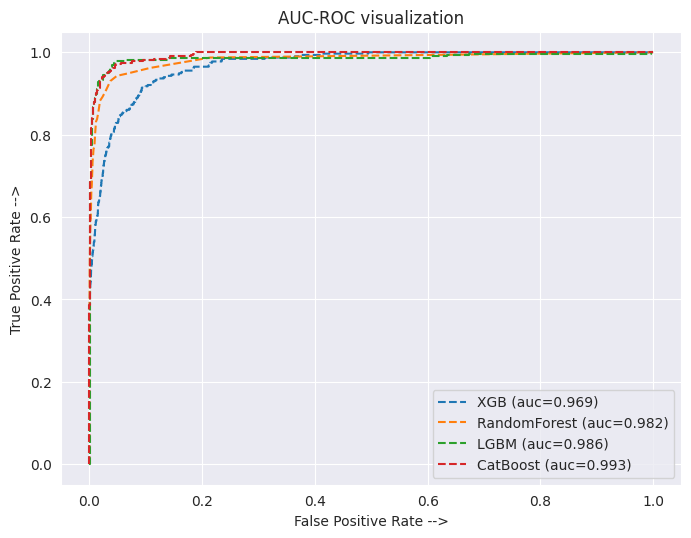

In [ ]:
# Visualization of AUC_ROC for mentioned models
xgb_fpr, xgb_tpr, threshold = roc_curve(val_y, y_pred_pr_xgb)
auc_xgb = auc(xgb_fpr, xgb_tpr)
rf_fpr, rf_tpr, threshold = roc_curve(val_y, y_pred_pr_rf)
auc_rf = auc(rf_fpr, rf_tpr)
lgbm_fpr, lgbm_tpr, threshold = roc_curve(val_y, y_pred_pr_lgbm)
auc_lgbm = auc(lgbm_fpr, lgbm_tpr)
catb_fpr, catb_tpr, threshold = roc_curve(val_y, y_pred_pr_catb)
auc_catb = auc(catb_fpr, catb_tpr)

plt.figure(figsize=(8,6), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, linestyle='--', label="XGB (auc=%0.3f)" % auc_xgb)
plt.plot(rf_fpr, rf_tpr, linestyle='--', label="RandomForest (auc=%0.3f)" % auc_rf)
plt.plot(lgbm_fpr, lgbm_tpr, linestyle='--', label="LGBM (auc=%0.3f)" % auc_lgbm)
plt.plot(catb_fpr, catb_tpr, linestyle='--', label="CatBoost (auc=%0.3f)" % auc_catb)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.title('AUC-ROC visualization')
plt.legend()
plt.show()

AUC-ROC plot also shows us the best models are CatBoost and LGBM as they have the biggest area covered, which means they are the best at distinguishing the target user.

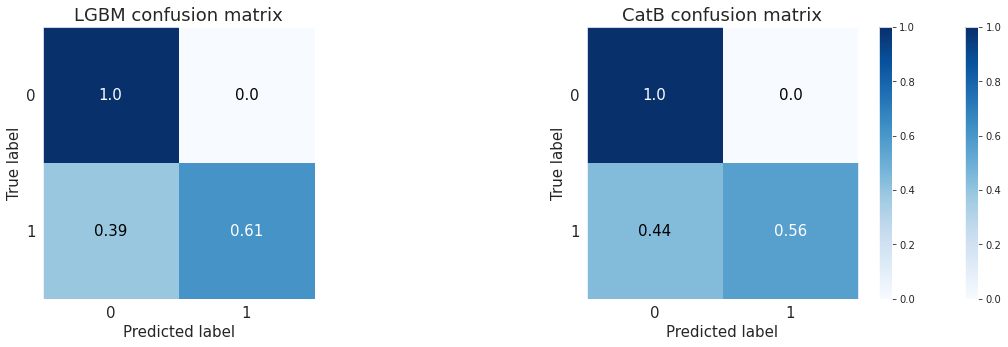

In [ ]:
# Visualization of confusion matrix for 2 best models
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))   
skplt.metrics.plot_confusion_matrix(val_y, y_pred_lgbm, normalize=True, title_fontsize=20, text_fontsize=15, ax=ax1)
ax1.set_title("LGBM confusion matrix", fontsize = 18)   
skplt.metrics.plot_confusion_matrix(val_y, y_pred_catb, normalize=True, title_fontsize=20, text_fontsize=15, ax=ax2)
ax2.set_title("CatB confusion matrix", fontsize = 18);


## Fixing unbalanced data

As metric selected AUC_ROC is not dependant of dataset balance this part could be skipped, but I did it just to check how other metrics can be improved

In [ ]:
# Resampling X and y datasets with SMOTE technique
sm = SMOTE(k_neighbors=3, random_state=0)
X_sm, y_sm = sm.fit_resample(train_X, train_y)
X_sm = pd.DataFrame(X_sm, columns=train_X.columns)
y_sm = pd.DataFrame(y_sm)

# Checking classes sizes changed after SMOTE
print('y after SMOTE:\n', y_sm.value_counts())

y after SMOTE:
 1    126715
0    126715
dtype: int64


In [ ]:
# Fitting models with resampled data and estimation results
fit_est_model(X_sm, y_sm, val_X, val_y, rf, 'RF')
fit_est_model(X_sm, y_sm, val_X, val_y, xgb, 'XGB')
fit_est_model(X_sm, y_sm, val_X, val_y, lgbm, 'LGBM')
fit_est_model(X_sm, y_sm, val_X, val_y, catb, 'CATB')

RF
AUC_ROC: 0.9803660930053808

REPORT:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     31815
           1       0.43      0.75      0.54       179

    accuracy                           0.99     31994
   macro avg       0.71      0.87      0.77     31994
weighted avg       1.00      0.99      0.99     31994

XGB
AUC_ROC: 0.9350412395773677

REPORT:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     30441
           1       0.60      0.12      0.20      1553

    accuracy                           0.95     31994
   macro avg       0.78      0.56      0.59     31994
weighted avg       0.94      0.95      0.94     31994

LGBM
AUC_ROC: 0.9923356166545662

REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31781
           1       0.61      0.90      0.72       213

    accuracy                           1.00     31994
  

(array([1.11234744e-05, 9.48232412e-07, 1.54841395e-01, ...,
        1.20355483e-06, 1.42566137e-04, 1.07818018e-03]),
 array([0, 0, 0, ..., 0, 0, 0]))

* After resampling auc_roc score become better only for LGBM model, end this difference is very small, for other models it become even worth, and as we need to stick to this metric in our task then resampling is not very good choice
* Other metrics like precision for minor class become better after resampling for all models


## Hyperparameters tuning

For every model hyperparameters tuning took pretty much time even with hyperopt, so for final notebook I left only few most successful, bigger amount was done previously

###XGBoost

To tune hyperparameters for XGBoost will be used hyperopt which uses Parsen Tree Algorithm to optimize the parameters search

In [ ]:
%%time

def objective(space):
    params = {
        'colsample_bytree': '{:.3f}'.format(space['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(space['learning_rate']),
        'alpha' : '{:.3f}'.format(space['alpha'])
    }
    
    clf = XGBClassifier(
        objective ='binary:logistic',
        random_state=0,
        n_estimators=3000,
        **params
    )
    
    score = cross_val_score(clf, train_X, train_y, scoring='roc_auc', cv=5).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.5),
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.3),
    'alpha': hp.uniform('alpha', 4, 5)
    }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5)

AUC 0.993 params {'colsample_bytree': '0.475', 'learning_rate': '0.222', 'alpha': '4.814'}
AUC 0.992 params {'colsample_bytree': '0.346', 'learning_rate': '0.255', 'alpha': '4.291'}
AUC 0.993 params {'colsample_bytree': '0.418', 'learning_rate': '0.146', 'alpha': '4.311'}
AUC 0.992 params {'colsample_bytree': '0.456', 'learning_rate': '0.232', 'alpha': '4.305'}
AUC 0.993 params {'colsample_bytree': '0.441', 'learning_rate': '0.113', 'alpha': '4.310'}
100%|██████████| 5/5 [1:05:24<00:00, 784.97s/it, best loss: 0.006628203899639806]
CPU times: user 1h 5min 33s, sys: 6.27 s, total: 1h 5min 39s
Wall time: 1h 5min 24s


In [ ]:
# Best parameters
best

{'alpha': 4.3101613843335045,
 'colsample_bytree': 0.4411368202324252,
 'learning_rate': 0.11250189267200704}

In [ ]:
best_xg_clf = XGBClassifier(objective ='binary:logistic', 
                            alpha=4.31,
                            colsample_bytree = 0.44,
                            learning_rate=0.11,
                            n_estimators=3000,
                            random_state=0)

fit_est_model(train_X, train_y, val_X, val_y, best_xg_clf, 'XGB_best')

XGB_best
AUC_ROC: 0.992898304770523

REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31768
           1       0.64      0.90      0.75       226

    accuracy                           1.00     31994
   macro avg       0.82      0.95      0.87     31994
weighted avg       1.00      1.00      1.00     31994



(array([5.7152061e-10, 1.2453971e-10, 1.4067714e-02, ..., 3.9249649e-11,
        2.8335776e-07, 6.4341492e-08], dtype=float32),
 array([0, 0, 0, ..., 0, 0, 0]))

XGBoost algorithm was improved with hyperparameters tuning to more then 99% auc_roc, which is very good

### LGBM

For LGBMClassifier GridSearch was used to find best parameters

In [ ]:
# tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
param_grid = {
    'max_depth': [-1, 5, 10],
    'n_estimators': [100, 1000, 2000]
}

lgbm = LGBMClassifier()
grid_search_lgbm = GridSearchCV(estimator = lgbm, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='roc_auc')

In [ ]:
%%time
grid_search_lgbm.fit(train_X, train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  6.2min finished


CPU times: user 22.7 s, sys: 489 ms, total: 23.2 s
Wall time: 6min 34s


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [-1, 5, 10],
                         'n_estimators': [100

In [ ]:
best_lgmb = grid_search_lgbm.best_estimator_
fit_est_model(train_X, train_y, val_X, val_y, best_lgmb, 'LGBM_best')

LGBM_best
AUC_ROC: 0.9917616046281724

REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31798
           1       0.58      0.93      0.71       196

    accuracy                           1.00     31994
   macro avg       0.79      0.96      0.86     31994
weighted avg       1.00      1.00      1.00     31994



(array([4.26316650e-09, 8.21693239e-13, 1.84151745e-03, ...,
        1.42369814e-15, 9.74868925e-07, 4.07478245e-07]),
 array([0, 0, 0, ..., 0, 0, 0]))

LGBMClassifier was also improved with tuned hyperparameters, but it had before also very good AUC_ROC score

### CatBoost

For CatBoostClassifier also GridSearch was used to find best parameters

In [ ]:
catb = CatBoostClassifier(loss_function='Logloss', verbose=False)

grid = {'learning_rate': [0.05, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 5, 9]}

grid_search_cb = GridSearchCV(estimator = catb, param_grid = grid, 
                          cv = 2, n_jobs = -1, verbose = False, scoring='roc_auc')

In [ ]:
%%time
grid_search_cb.fit(train_X, train_y)

CPU times: user 1min 49s, sys: 3.13 s, total: 1min 52s
Wall time: 38min 23s


GridSearchCV(cv=2, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f9c24ebca90>,
             iid='deprecated', n_jobs=-1,
             param_grid={'depth': [4, 6, 10], 'l2_leaf_reg': [1, 5, 9],
                         'learning_rate': [0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=False)

In [ ]:
grid_search_cb.best_params_

{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

In [ ]:
best_catb = CatBoostClassifier(depth = 6, l2_leaf_reg = 5, learning_rate = 0.1, loss_function='Logloss', verbose=0)
fit_est_model(train_X, train_y, val_X, val_y, best_catb, 'CATB_best')

CATB_best
AUC_ROC: 0.9937685422770179

REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31809
           1       0.54      0.92      0.68       185

    accuracy                           1.00     31994
   macro avg       0.77      0.96      0.84     31994
weighted avg       1.00      1.00      1.00     31994



(array([6.14441844e-06, 7.94682269e-07, 3.59553991e-02, ...,
        4.54321289e-09, 1.58185893e-04, 5.47660633e-04]),
 array([0, 0, 0, ..., 0, 0, 0]))

CatBoostClassifier was slightly improved with tuned hyperparameters, but it had before also very good AUC_ROC score

# Some additional ideas

I was trying to add some new features for my data, but it didn't give me improvement for the score as I was expected

In [ ]:
# Sorting all webpages for zero user
all_sites_zero = pd.Series(train[target==0][webpages]
                           .values
                           .flatten()
                           ).value_counts().sort_values(ascending=False)
all_sites_zero = pd.DataFrame(all_sites_zero)
list_zero = list(all_sites_zero.index)

# Sorting all webpages for zero user
all_sites_one = pd.Series(train[target==1][webpages]
                           .values
                           .flatten()
                           ).value_counts().sort_values(ascending=False)
all_sites_one = pd.DataFrame(all_sites_one)
list_one = list(all_sites_one.index)

# Removing common webpages for one and zero user to create 2 lists with unique for one and zero user webpages
intsec = set(list_one).intersection(set(list_zero))
intsec = list(intsec)
for i in intsec:
  list_one.remove(i)
  list_zero.remove(i)

# Creating list of webpages for every record
df = train[webpages]
sites_list = df.values.tolist()
df['sites_list']=sites_list

In [ ]:
# Validating if page from unique list is in sites_list
one_validation=[]
for i in df.sites_list:
  if set(list_one).isdisjoint(set(i)):
    one_validation.append(0)
  else:
    one_validation.append(1)

zero_validation=[]
for i in df.sites_list:
  if set(list_zero).isdisjoint(set(i)):
    zero_validation.append(0)
  else:
    zero_validation.append(1)
    
# Creating 2 new boolean features
train['is_webp_unique_target'] = one_validation
train['is_webp_unique_others'] = zero_validation

In [ ]:
# For final result I've dropped those features as they didn't improve my results
train.drop('is_webp_unique_others', axis=1, inplace=True)
train.drop('is_webp_unique_target', axis=1, inplace=True)

## Final result

For our competition task I've used 3 models XGBoost, LGBM and CatBoost with tuned hyperparameters and all of them gave me score more then 94% on test data, but then I've changed a little LGBM model and get 95% for AUC_ROC on test data. Exact model used is below.

In [ ]:
# Best LGBM model selected
lg = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=900, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Fitting the model with whole train dataset
lg.fit(train, target)

In [ ]:
# Function for saving submission
def save_submission(pred):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('lg_best.csv')

In [ ]:
# Saving predicted results
pred = lg.predict_proba(test)[:, 1]
save_submission(pred)

# Downloading file
# from google.colab import files
# files.download("lg_best.csv")

# Conclusion

* We have checked different models for our task
* Used different techniques for hyperparameters tuning with some improved result after it
* For our task best models were LGBM and CatBoostClassifier, but further investigation can be done
